In [158]:
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import matplotlib.pyplot as plt
import re

import folium
import rasterio
import rasterio.mask

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from geopy.distance import geodesic
import folium
from sklearn.tree import DecisionTreeClassifier

In [159]:
incoming_weather_size_draught = pd.read_csv('Data/Input_ML/incoming_weather_size_draught.csv')
incoming_weather_size = pd.read_csv('Data/Input_ML/incoming_weather_size.csv')
incoming_weather = pd.read_csv('Data/Input_ML/incoming_weather.csv')

In [160]:
# Assuming 'column_name' is the name of the column containing strings in your DataFrame
label_encoder = LabelEncoder()
incoming_weather_size_draught['Direction'] = label_encoder.fit_transform(incoming_weather_size_draught['Direction'])
incoming_weather_size_draught['Wind_speed'] = label_encoder.fit_transform(incoming_weather_size_draught['Wind_speed'])
incoming_weather_size_draught['Type'] = label_encoder.fit_transform(incoming_weather_size_draught['Type'])
#incoming_weather_size_draught['to_haven'] = label_encoder.fit_transform(incoming_weather_size_draught['to_haven'])
incoming_weather_size_draught

,Unnamed: 0,area_ID,geometry,center,index_right,from,from_rounded,from_location,to_haven,trip_ID,...,Datetime,Direction,Wind_speed,device_mmsi_x,Lenght,Width,Type,device_mmsi_y,Navigation_draught,DateTime
0,0,1584,"POLYGON ((4.141337398344955 51.96305993744309,...",POINT (4.144184602671961 51.96555611267637),8,2022-05-31 23:34:58+00:00,2022-06-01 00:00:00+00:00,"[4.14163, 51.96557]",3PET,4,...,2022-06-01 00:00:00+00:00,6,2,538005865.0,159.0,27.0,2,538005865,8.3,2022-06-01 00:00:00+00:00
1,1,2573,POLYGON ((4.306675663908258 51.893109132781674...,POINT (4.303422040818236 51.89574030099446),10632,2022-09-08 07:01:29+00:00,2022-09-08 07:00:00+00:00,"[4.30278, 51.89511]",1PET,6054,...,2022-09-08 07:00:00+00:00,5,3,538005865.0,159.0,27.0,2,538005865,9.6,2022-09-08 07:00:00+00:00
2,2,1820,MULTIPOLYGON (((4.185851546765845 51.937623281...,POINT (4.182629270525373 51.940406444127476),10997,2022-09-11 04:34:51+00:00,2022-09-11 05:00:00+00:00,"[4.17956, 51.93872]",CKBRUG,6258,...,2022-09-11 05:00:00+00:00,0,2,538005865.0,159.0,27.0,2,538005865,9.0,2022-09-11 05:00:00+00:00
3,3,2335,"POLYGON ((4.268520679547496 51.90582746090193,...",POINT (4.2649075344304945 51.90749906115681),20123,2022-11-24 02:30:45+00:00,2022-11-24 03:00:00+00:00,"[4.26256, 51.90621]",3PET,11529,...,2022-11-24 03:00:00+00:00,7,1,538005865.0,159.0,27.0,2,538005865,7.6,2022-11-24 03:00:00+00:00
4,4,2453,MULTIPOLYGON (((4.284689496769173 51.893109132...,POINT (4.284735186045074 51.89810584295877),14458,2022-10-10 08:13:47+00:00,2022-10-10 08:00:00+00:00,"[4.28256, 51.89866]",TORONT,8267,...,2022-10-10 08:00:00+00:00,5,3,538005077.0,158.0,27.0,2,538005077,10.3,2022-10-10 08:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4042,4042,1661,POLYGON ((4.154055726465209 51.950341609322834...,POINT (4.1582292726911 51.9480457533607),23823,2022-12-25 00:56:07+00:00,2022-12-25 01:00:00+00:00,"[4.15802, 51.95009]",7PET,13637,...,2022-12-25 01:00:00+00:00,5,3,538003962.0,183.0,32.0,2,538003962,11.3,2022-12-25 01:00:00+00:00
4043,4043,1027,"POLYGON ((4.052309101503177 51.98849659368361,...",POINT (4.05548868353324 51.98531701165355),23850,2022-12-25 08:17:19+00:00,2022-12-25 08:00:00+00:00,"[4.05757, 51.98543]",SCHEUR,13651,...,2022-12-25 08:00:00+00:00,5,3,477345300.0,225.0,32.0,0,477345300,14.0,2022-12-25 08:00:00+00:00
4044,4044,1265,"POLYGON ((4.090464085863939 51.96941910150322,...",POINT (4.093582835562203 51.97266975312477),23857,2022-12-25 10:19:15+00:00,2022-12-25 10:00:00+00:00,"[4.09324, 51.97466]",5PET,13655,...,2022-12-25 10:00:00+00:00,5,3,538008798.0,245.0,42.0,2,538008798,15.3,2022-12-25 10:00:00+00:00
4045,4045,2573,POLYGON ((4.306675663908258 51.893109132781674...,POINT (4.303422040818236 51.89574030099446),23867,2022-12-25 12:25:08+00:00,2022-12-25 12:00:00+00:00,"[4.30134, 51.89561]",2PET,13660,...,2022-12-25 12:00:00+00:00,5,3,403579000.0,183.0,32.0,2,403579000,11.4,2022-12-25 12:00:00+00:00


In [161]:
leaving_weather_size_draught = pd.read_csv('Data/Input_ML/leaving_weather_size_draught.csv')
leaving_weather_size = pd.read_csv('Data/Input_ML/leaving_weather_size.csv')
leaving_weather = pd.read_csv('Data/Input_ML/leaving_weather.csv')

In [162]:
# Assuming 'column_name' is the name of the column containing strings in your DataFrame
label_encoder = LabelEncoder()
leaving_weather_size_draught['Direction'] = label_encoder.fit_transform(leaving_weather_size_draught['Direction'])
leaving_weather_size_draught['Wind_speed'] = label_encoder.fit_transform(leaving_weather_size_draught['Wind_speed'])
leaving_weather_size_draught['Type'] = label_encoder.fit_transform(leaving_weather_size_draught['Type'])
#leaving_weather_size_draught['from_haven'] = label_encoder.fit_transform(leaving_weather_size_draught['from_haven'])

In [163]:
leaving_top = leaving_weather_size_draught['from_haven'].value_counts()
incoming_top = incoming_weather_size_draught['to_haven'].value_counts()
print(leaving_top[0:2])
print(incoming_top[0:2])

from_haven
EURO      451
AMALIA    309
Name: count, dtype: int64
to_haven
EURO    480
7PET    377
Name: count, dtype: int64


In [164]:
top_leaving = 'EURO'
top_incoming = 'EURO'

harbor_leaving = leaving_weather_size_draught[leaving_weather_size_draught['from_haven']== top_leaving]
harbor_incoming = incoming_weather_size_draught[incoming_weather_size_draught['to_haven']== top_incoming]


In [165]:
columns_leaving = [
    #'from_haven',
    'Direction',
    'Wind_speed',
    'Lenght'	,
    'Width'	,
    'Type'
]

columns_incoming = [
    #'to_haven',
    'Direction',
    'Wind_speed',
    'Lenght'	,
    'Width'	,
    'Type'
]


In [166]:
X = harbor_leaving[columns_leaving]
y = harbor_leaving['area_ID']

X_from_lat_train, X_from_lat_test, y_from_lat_train, y_from_lat_test = train_test_split(X, y, test_size=0.3, random_state=3)
#X_from_lat_train, X_from_lat_test, y_from_lat_train, y_from_lat_test = train_test_split(leaving_weather_size_draught[columns_leaving], leaving_weather_size_draught['area_ID'], test_size=0.3, random_state=42)
data = X_from_lat_test

#from sklearn.datasets import load_iris
#iris = load_iris()
#X_from_lat_train, y_from_lat_train = iris.data, iris.target



In [167]:
print("Number of features in training data:", X_from_lat_train.shape[1])
print("Number of features in test data:", X_from_lat_test.shape[1])


X_from_lat_train

Number of features in training data: 5
Number of features in test data: 5


,Direction,Wind_speed,Lenght,Width,Type
1499,1,3,300.0,40.0,0
1747,5,3,199.0,30.0,0
153,2,1,228.0,37.0,0
2994,5,3,330.0,48.0,0
1502,7,3,300.0,40.0,0
...,...,...,...,...,...
3385,0,3,300.0,40.0,0
791,5,3,294.0,32.0,0
1523,8,3,300.0,48.0,0
899,5,1,280.0,32.0,0


In [168]:
X_from_lat_test

,Direction,Wind_speed,Lenght,Width,Type
1247,7,3,228.0,37.0,0
596,8,3,275.0,40.0,0
1406,5,2,300.0,48.0,0
1003,8,3,300.0,43.0,0
2993,0,3,330.0,48.0,0
...,...,...,...,...,...
1902,2,2,337.0,46.0,0
2767,7,3,284.0,40.0,0
952,7,2,333.0,48.0,0
535,8,1,333.0,48.0,0


In [169]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.datasets import load_iris


# Initialize the Decision Tree Classifier
decision_tree_classifier = DecisionTreeClassifier(random_state=3)

# Train the classifier using the training data
x = decision_tree_classifier.fit(X_from_lat_train, y_from_lat_train)

# Make predictions on the test data
predictions = decision_tree_classifier.predict(X_from_lat_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_from_lat_test, predictions)

print("Accuracy of the Decision Tree Classifier: {:.2f}%".format(accuracy * 100))

# Add predictions to the original DataFrame

data['Predicted_Area_ID'] = predictions
data



Accuracy of the Decision Tree Classifier: 17.65%


,Direction,Wind_speed,Lenght,Width,Type,Predicted_Area_ID
1247,7,3,228.0,37.0,0,1224
596,8,3,275.0,40.0,0,1226
1406,5,2,300.0,48.0,0,1224
1003,8,3,300.0,43.0,0,1224
2993,0,3,330.0,48.0,0,1225
...,...,...,...,...,...,...
1902,2,2,337.0,46.0,0,1186
2767,7,3,284.0,40.0,0,1225
952,7,2,333.0,48.0,0,1225
535,8,1,333.0,48.0,0,1225


[Text(0.38565211885131356, 0.975, 'x[2] <= 280.5\ngini = 0.852\nsamples = 315\nvalue = [1, 1, 1, 1, 1, 2, 2, 1, 3, 1, 1, 2, 1, 7\n2, 5, 6, 1, 10, 9, 13, 1, 25, 4, 2, 32, 8\n81, 75, 15, 1]'),
 Text(0.19494785844046952, 0.925, 'x[3] <= 43.0\ngini = 0.87\nsamples = 139\nvalue = [1, 0, 1, 0, 1, 0, 2, 0, 1, 1, 1, 1, 0, 5\n2, 0, 6, 1, 7, 9, 4, 0, 16, 0, 1, 15, 3, 39\n16, 5, 1]'),
 Text(0.14952924119619898, 0.875, 'x[1] <= 1.5\ngini = 0.865\nsamples = 136\nvalue = [0, 0, 1, 0, 1, 0, 2, 0, 1, 1, 1, 1, 0, 5\n2, 0, 4, 1, 7, 9, 4, 0, 16, 0, 1, 15, 3, 39\n16, 5, 1]'),
 Text(0.07210732252655115, 0.825, 'x[2] <= 268.5\ngini = 0.865\nsamples = 34\nvalue = [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0\n2, 0, 1, 0, 3, 0, 0, 0, 8, 0, 0, 3, 0, 6\n5, 2, 0]'),
 Text(0.04136389044158748, 0.775, 'x[3] <= 25.5\ngini = 0.862\nsamples = 28\nvalue = [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0\n2, 0, 1, 0, 2, 0, 0, 0, 8, 0, 0, 3, 0, 3\n3, 2, 0]'),
 Text(0.017887087758524316, 0.725, 'x[4] <= 0.5\ngini = 0.781\nsamples =

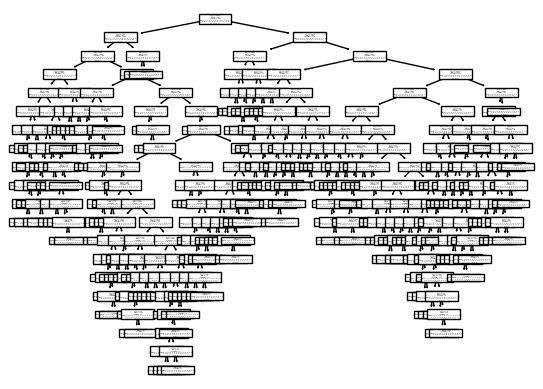

In [170]:
tree.plot_tree(x)

In [172]:
merged_df = pd.merge(data, leaving_weather_size_draught, left_index=True, right_index=True, how='left')
merged_df

,Direction_x,Wind_speed_x,Lenght_x,Width_x,Type_x,Predicted_Area_ID,Unnamed: 0,area_ID,geometry,center,...,Datetime,Direction_y,Wind_speed_y,device_mmsi_x,Lenght_y,Width_y,Type_y,device_mmsi_y,Navigation_draught,DateTime
1247,7,3,228.0,37.0,0,1224,1247,1225,"POLYGON ((4.084104921803812 51.97577826556335,...",POINT (4.087284503833875 51.972598683533285),...,2022-07-03 00:00:00+00:00,7,3,636093114.0,228.0,37.0,0,636093114,10.2,2022-07-03 00:00:00+00:00
596,8,3,275.0,40.0,0,1226,596,1224,"POLYGON ((4.084104921803812 51.96941910150322,...",POINT (4.087284503833875 51.966239519473156),...,2022-06-12 14:00:00+00:00,8,3,477346500.0,275.0,40.0,0,477346500,13.9,2022-06-12 14:00:00+00:00
1406,5,2,300.0,48.0,0,1224,1406,1186,"POLYGON ((4.084104921803812 51.97577826556335,...",POINT (4.080886877262364 51.97886976519479),...,2022-11-12 16:00:00+00:00,5,2,255805929.0,300.0,48.0,0,255805929,12.3,2022-11-12 16:00:00+00:00
1003,8,3,300.0,43.0,0,1224,1003,1186,"POLYGON ((4.084104921803812 51.97577826556335,...",POINT (4.080886877262364 51.97886976519479),...,2022-06-24 14:00:00+00:00,8,3,219088000.0,300.0,43.0,0,219088000,11.4,2022-06-24 14:00:00+00:00
2993,0,3,330.0,48.0,0,1225,2993,1224,"POLYGON ((4.084104921803812 51.96941910150322,...",POINT (4.087284503833875 51.966239519473156),...,2022-10-19 23:00:00+00:00,0,3,255806031.0,330.0,48.0,0,255806031,11.2,2022-10-19 23:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1902,2,2,337.0,46.0,0,1186,1902,1224,"POLYGON ((4.084104921803812 51.96941910150322,...",POINT (4.087284503833875 51.966239519473156),...,2022-07-23 18:00:00+00:00,2,2,209251000.0,337.0,46.0,0,209251000,11.4,2022-07-23 18:00:00+00:00
2767,7,3,284.0,40.0,0,1225,2767,1225,"POLYGON ((4.084104921803812 51.97577826556335,...",POINT (4.087284503833875 51.972598683533285),...,2022-10-03 12:00:00+00:00,7,3,371799000.0,284.0,40.0,0,371799000,8.8,2022-10-03 12:00:00+00:00
952,7,2,333.0,48.0,0,1225,952,1224,"POLYGON ((4.084104921803812 51.96941910150322,...",POINT (4.087284503833875 51.966239519473156),...,2022-08-23 08:00:00+00:00,7,2,219096000.0,333.0,48.0,0,219096000,10.2,2022-08-23 08:00:00+00:00
535,8,1,333.0,48.0,0,1225,535,1225,"POLYGON ((4.084104921803812 51.97577826556335,...",POINT (4.087284503833875 51.972598683533285),...,2022-07-25 21:00:00+00:00,8,1,219100000.0,333.0,48.0,0,219100000,10.1,2022-07-25 21:00:00+00:00


In [173]:
# Create a new empty list to store prediction_center values
prediction_centers = []

# Iterate through the rows of merged_df
for index, row in merged_df.iterrows():
    # Get the Predicted_Area_ID value from the current row of merged_df
    predicted_area_id = row['Predicted_Area_ID']
    
    # Find the corresponding row in incoming_weather_size_draught where area_ID matches Predicted_Area_ID
    matching_row = incoming_weather_size_draught[incoming_weather_size_draught['area_ID'] == predicted_area_id]
    
    # Check if a matching row is found
    if not matching_row.empty:
        # Get the value from the 'center' column in the matching row
        prediction_center = matching_row['center'].values[0]
    else:
        # If no matching row is found, assign a default value (you can change this as per your requirement)
        prediction_center = None
    
    # Append the prediction_center value to the list
    prediction_centers.append(prediction_center)

# Add the prediction_centers list as a new column to merged_df
merged_df['prediction_center'] = prediction_centers

In [174]:
merged_df

,Direction_x,Wind_speed_x,Lenght_x,Width_x,Type_x,Predicted_Area_ID,Unnamed: 0,area_ID,geometry,center,...,Direction_y,Wind_speed_y,device_mmsi_x,Lenght_y,Width_y,Type_y,device_mmsi_y,Navigation_draught,DateTime,prediction_center
1247,7,3,228.0,37.0,0,1224,1247,1225,"POLYGON ((4.084104921803812 51.97577826556335,...",POINT (4.087284503833875 51.972598683533285),...,7,3,636093114.0,228.0,37.0,0,636093114,10.2,2022-07-03 00:00:00+00:00,POINT (4.087284503833875 51.966239519473156)
596,8,3,275.0,40.0,0,1226,596,1224,"POLYGON ((4.084104921803812 51.96941910150322,...",POINT (4.087284503833875 51.966239519473156),...,8,3,477346500.0,275.0,40.0,0,477346500,13.9,2022-06-12 14:00:00+00:00,POINT (4.087283586425642 51.978914556890544)
1406,5,2,300.0,48.0,0,1224,1406,1186,"POLYGON ((4.084104921803812 51.97577826556335,...",POINT (4.080886877262364 51.97886976519479),...,5,2,255805929.0,300.0,48.0,0,255805929,12.3,2022-11-12 16:00:00+00:00,POINT (4.087284503833875 51.966239519473156)
1003,8,3,300.0,43.0,0,1224,1003,1186,"POLYGON ((4.084104921803812 51.97577826556335,...",POINT (4.080886877262364 51.97886976519479),...,8,3,219088000.0,300.0,43.0,0,219088000,11.4,2022-06-24 14:00:00+00:00,POINT (4.087284503833875 51.966239519473156)
2993,0,3,330.0,48.0,0,1225,2993,1224,"POLYGON ((4.084104921803812 51.96941910150322,...",POINT (4.087284503833875 51.966239519473156),...,0,3,255806031.0,330.0,48.0,0,255806031,11.2,2022-10-19 23:00:00+00:00,POINT (4.087284503833875 51.972598683533285)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1902,2,2,337.0,46.0,0,1186,1902,1224,"POLYGON ((4.084104921803812 51.96941910150322,...",POINT (4.087284503833875 51.966239519473156),...,2,2,209251000.0,337.0,46.0,0,209251000,11.4,2022-07-23 18:00:00+00:00,POINT (4.080886877262364 51.97886976519479)
2767,7,3,284.0,40.0,0,1225,2767,1225,"POLYGON ((4.084104921803812 51.97577826556335,...",POINT (4.087284503833875 51.972598683533285),...,7,3,371799000.0,284.0,40.0,0,371799000,8.8,2022-10-03 12:00:00+00:00,POINT (4.087284503833875 51.972598683533285)
952,7,2,333.0,48.0,0,1225,952,1224,"POLYGON ((4.084104921803812 51.96941910150322,...",POINT (4.087284503833875 51.966239519473156),...,7,2,219096000.0,333.0,48.0,0,219096000,10.2,2022-08-23 08:00:00+00:00,POINT (4.087284503833875 51.972598683533285)
535,8,1,333.0,48.0,0,1225,535,1225,"POLYGON ((4.084104921803812 51.97577826556335,...",POINT (4.087284503833875 51.972598683533285),...,8,1,219100000.0,333.0,48.0,0,219100000,10.1,2022-07-25 21:00:00+00:00,POINT (4.087284503833875 51.972598683533285)


In [175]:
# Function to convert string representation of coordinates to actual coordinates
def parse_coordinates(coord_str):
    if coord_str:
        # Extract numerical values from the string (format: 'POINT (longitude latitude)')
        coordinates = re.findall(r"[-+]?\d*\.\d+|\d+", coord_str)
        lat, lon = map(float, coordinates)
        return lat, lon
    else:
        return None

# Convert 'from_location' and 'center' columns to actual coordinates
merged_df['to_location_coords'] = merged_df['to_location'].apply(parse_coordinates)
merged_df['center_coords'] = merged_df['prediction_center'].apply(parse_coordinates)

# Function to calculate distance between two points using geodesic
def calculate_distance(row):
    if row['to_location_coords'] and row['center_coords']:
        return geodesic(row['to_location_coords'], row['center_coords']).meters
    else:
        return None

# Apply the calculate_distance function to the DataFrame to compute distances
merged_df['distance_to_predicted_center'] = merged_df.apply(calculate_distance, axis=1)
moyenne_distance = merged_df['distance_to_predicted_center'].mean()

# Afficher la moyenne
print("Average distance between predicted and real locations: ", moyenne_distance, "meters")



Average distance between predicted and real locations:  1448.1198754338066 meters


In [ ]:
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X, y)